In [ ]:
#Imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline

In [2]:
#Auxiliary funtions
def get_seasonal_cycle(X,y,start_year,seasonal_period):
    """
    Gets the seasonal period value of observations
    """
    #Get the centering value
    half_cycle_value=(seasonal_period-1)/2
    #Populate the feature df
    X['Season_Period']=abs(((y.index.year-start_year)%seasonal_period-half_cycle_value)
                                /half_cycle_value)
    return X

def moving_average(X,y,target,months):
    """
    Calculates the moving average of past observations
    """
    #Shifts dataset by 1
    shifted_y=y.shift(1)
    #Populate the feature df
    X['Moving_Average']=shifted_y[target].rolling(window=months).mean()
    return X

def create_lags(X,y,target,lag=2):
    """
    Returns the past values of a column (simplification of original function)
    """
    for l in range(1,lag+1):
        X[target+f'_lag_{l}']=y[target].shift(l)
    return X

In [3]:
# Custom Classes
class Hacky_Object():
    def __init__(self,X=None,y=None,target=None):
        #store X and Y
        self.X=X
        self.y=y
        self.target=target
        
class Hacky_Model(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    def fit(self,X, y=None):
        self.X_ = X.X
        self.y_ = X.y
        # Return the classifier
        return self.model.fit(X.X,X.y)

    def predict(self, X):
        return self.model.predict(X.X)

class MA_Transformer(BaseEstimator, TransformerMixin):
    """
    Transformer class to calculate moving averages 
    """
    def __init__(self,months):
        self.months=months
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X.copy()
        y_data=X.y.copy()
        target=X.target
        # Add Object atributes for debbuging
        self.data_in=X_data.copy()
        
        # Call transformation function
        X_data=moving_average(X_data,y_data,target,self.months)
        X.X=X_data
        # Add Object atributes for debbuging
        self.data_out=X_data.copy()
        return X
    
class Season_Transformer(BaseEstimator, TransformerMixin):
    """
    Transformer class to retrieve seasonal periods
    """
    def __init__(self,start_year,seasonal_period):
        self.start_year=start_year
        self.seasonal_period=seasonal_period
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X.copy()
        y_data=X.y.copy()
        target=X.target
        # Add Object atributes for debbuging
        self.data_in=X_data.copy()
        
        # Call transformation function
        X_data=get_seasonal_cycle(X_data,y_data,self.start_year,self.seasonal_period)
        X.X=X_data
        # Add Object atributes for debbuging
        self.data_out=X_data.copy()
        return X

class Lag_Transformer(BaseEstimator, TransformerMixin):
    """
    Transformer class to calculate data lags 
    """
    def __init__(self,lag):
        self.lag=lag
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X.copy()
        y_data=X.y.copy()
        target=X.target
        # Add Object atributes for debbuging
        self.data_in=X_data.copy()
        
        # Call transformation function
        X_data=create_lags(X_data,y_data,target,self.lag)
        X.X=X_data
        # Add Object atributes for debbuging
        self.data_out=X_data.copy()
        return X

class Dropna(BaseEstimator, TransformerMixin):
    """
    Transformer class to drop nan values
    """
    def __init__(self):
        pass
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X.copy()
        y_data=X.y.copy()
        target=X.target
        # Add Object atributes for debbuging
        self.data_in=X_data.copy()
        
        # Drop nan values
        X_data=X_data.dropna()
        y_data=y_data.loc[X_data.index]
        X.X=X_data
        X.y=y_data
        # Add Object atributes for debbuging
        self.data_out=X_data.copy()
        return X

In [4]:
#Get Our Data
url='https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
contents=requests.get(url).content
Sunspot_Df=pd.read_csv(StringIO(contents.decode('utf-8')))

#Index by datetime

Sunspot_Df['Month']=pd.to_datetime(Sunspot_Df['Month'],format='%Y-%m')
Sunspot_Df=Sunspot_Df.set_index('Month')

#Store it

Data_Obj=Hacky_Object(X=pd.DataFrame(),y=Sunspot_Df,target='Sunspots')

#Create Pipeline
pd.set_option("display.max_columns", 8)
My_Pipeline=Pipeline([('Moving Average',MA_Transformer(months=12*11)),
                     ('Season',Season_Transformer(start_year=1750,seasonal_period=11)),
                     ('Lags',Lag_Transformer(lag=12)),
                     ('Dropna',Dropna())])

#Transform Data
Data_Obj=My_Pipeline.transform(Data_Obj)

#Train and test split
X_train=Data_Obj.X.loc[:datetime(1930,1,1)]
X_test=Data_Obj.X.loc[datetime(1930,1,1):]
y_train=Data_Obj.y.loc[:datetime(1930,1,1)]
y_test=Data_Obj.y.loc[datetime(1930,1,1):]
DataObj_train=Hacky_Object(X=X_train,y=y_train,target='Sunspots')
DataObj_test=Hacky_Object(X=X_test,y=y_test,target='Sunspots')

#Create model
reg = ensemble.GradientBoostingRegressor()
Model=Hacky_Model(reg)
Model.fit(DataObj_train)

#Check scores
mse = mean_squared_error(y_test, Model.predict(DataObj_test))
r2= r2_score(y_test, Model.predict(DataObj_test))
mae=mean_absolute_error(y_test, Model.predict(DataObj_test))
mse_train = mean_squared_error(y_train, Model.predict(DataObj_train))
r2_train = r2_score(y_train, Model.predict(DataObj_train))
mae_train=mean_absolute_error(y_train, Model.predict(DataObj_train))
print(f'Train scores: R2:{r2_train}   MAE:{mae_train}    RMSE{mse_train**0.5}')
print(f'Test scores: R2:{r2}   MAE:{mae}    RMSE{mse**0.5}')

C:\Users\chhs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train scores: R2:0.9017749233652163   MAE:8.809551885238657    RMSE11.886974636193624
Test scores: R2:0.8770990914913496   MAE:13.936889989843229    RMSE19.201954657745745


<AxesSubplot:xlabel='Month'>

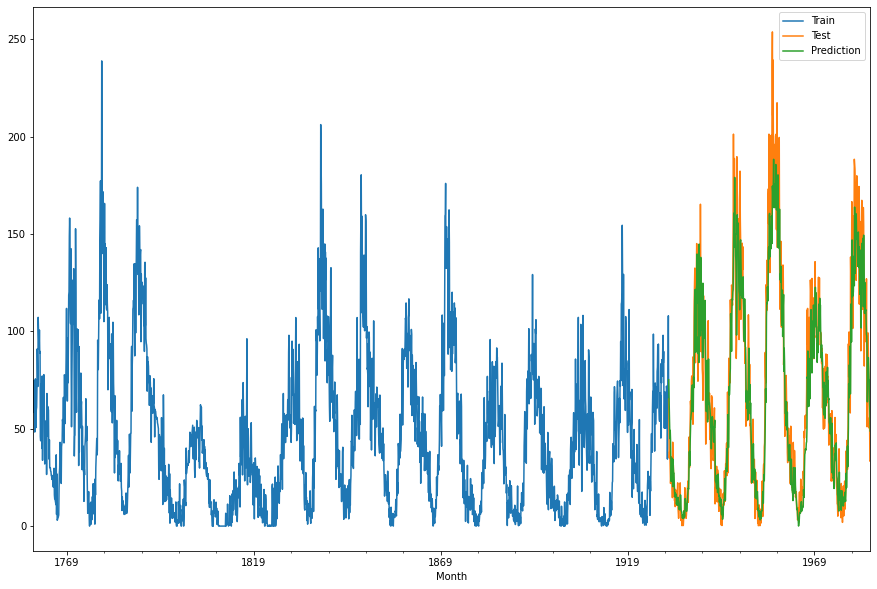

In [6]:
#plot Resuts
ax=y_train.rename(columns={'Sunspots':'Train'}).plot( figsize=(15,10))
y_test.rename(columns={'Sunspots':'Test'}).plot(ax=ax)
preds=pd.DataFrame()
preds['Prediction']=Model.predict(DataObj_test)
preds.index=y_test.index
preds.plot(ax=ax)